# 03 - Hyperparameter Optimization 
## Otimização Avançada

---

## Objetivo

Implementar otimizações avançadas de hiperparâmetros e métodos ensemble para maximizar a performance de detecção de fraude, construindo sobre os baselines estabelecidos.

## Dimensões de Análise

| Bayesian | Ensemble | Feature | Threshold |
|----------|----------|---------|-----------|
| Tuning | Methods | Selection | Calibration |

## Questões de Pesquisa

1. Qual é o ganho de performance com otimização bayesiana vs. grid search?
2. Como os métodos ensemble (Stacking/Blending) se comparam aos modelos individuais?
3. Quais features são mais importantes após seleção avançada?
4. Qual é o threshold ótimo para maximizar business value?

---

In [1]:
# ============================================================================
# 1. IMPORT REQUIRED LIBRARIES
# ============================================================================

import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Advanced Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Ensemble Methods
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Feature Selection
from sklearn.feature_selection import RFE, RFECV, SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures

# Model Evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import (precision_recall_curve, roc_curve, roc_auc_score,
                           classification_report, confusion_matrix,
                           recall_score, precision_score, f1_score,
                           accuracy_score, average_precision_score,
                           make_scorer)
from sklearn.calibration import calibration_curve

# Statistical Tests
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("LIBRARIES IMPORTED SUCCESSFULLY")
print("=" * 80)

LIBRARIES IMPORTED SUCCESSFULLY


In [2]:
# ============================================================================
# 2. LOAD PHASE 1 ARTIFACTS AND DATA
# ============================================================================

# Add project root to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # notebooks/07_model_dev -> notebooks -> project_root
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Also add the utils directory directly
utils_path = project_root / 'utils'
if str(utils_path) not in sys.path:
    sys.path.append(str(utils_path))

# Import custom modules
try:
    from utils.data import load_artifact, save_artifact
    from utils.preprocessing import create_advanced_features
    from utils.modeling import FraudMetrics
    from utils.visualization import plot_feature_importance, plot_fraud_patterns
    import utils.explainability as explainability

    # New optimized utils modules
    from utils.optimization import BayesianOptimizer, create_temporal_cv_splits, run_comprehensive_optimization
    from utils.ensembles import (WeightedEnsemble, create_stacking_ensemble, create_voting_ensemble,
                                evaluate_ensemble_methods, evaluate_model_cv, select_best_ensemble)
    from utils.feature_selection import AdvancedFeatureSelector
    from utils.calibration import ThresholdOptimizer, ProbabilityCalibrator, optimize_threshold_and_calibrate
    from utils.evaluation import ModelEvaluator, SHAPAnalyzer, plot_shap_analysis

    print("Custom modules imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("Trying alternative import method...")
    # Alternative import method
    import importlib.util

    def load_module_from_path(module_name, file_path):
        spec = importlib.util.spec_from_file_location(module_name, file_path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        return module

    # Load modules directly
    utils_path = project_root / 'utils'
    data_module = load_module_from_path('utils.data', utils_path / 'data.py')
    preprocessing_module = load_module_from_path('utils.preprocessing', utils_path / 'preprocessing.py')
    modeling_module = load_module_from_path('utils.modeling', utils_path / 'modeling.py')
    visualization_module = load_module_from_path('utils.visualization', utils_path / 'visualization.py')
    explainability_module = load_module_from_path('utils.explainability', utils_path / 'explainability.py')

    # Load new optimized modules
    optimization_module = load_module_from_path('utils.optimization', utils_path / 'optimization.py')
    ensembles_module = load_module_from_path('utils.ensembles', utils_path / 'ensembles.py')
    feature_selection_module = load_module_from_path('utils.feature_selection', utils_path / 'feature_selection.py')
    calibration_module = load_module_from_path('utils.calibration', utils_path / 'calibration.py')
    evaluation_module = load_module_from_path('utils.evaluation', utils_path / 'evaluation.py')

    load_artifact = data_module.load_artifact
    save_artifact = data_module.save_artifact
    create_advanced_features = preprocessing_module.create_advanced_features
    FraudMetrics = modeling_module.FraudMetrics
    plot_feature_importance = visualization_module.plot_feature_importance
    plot_fraud_patterns = visualization_module.plot_fraud_patterns
    explainability = explainability_module

    # Import new optimized classes and functions
    BayesianOptimizer = optimization_module.BayesianOptimizer
    create_temporal_cv_splits = optimization_module.create_temporal_cv_splits
    run_comprehensive_optimization = optimization_module.run_comprehensive_optimization

    WeightedEnsemble = ensembles_module.WeightedEnsemble
    create_stacking_ensemble = ensembles_module.create_stacking_ensemble
    create_voting_ensemble = ensembles_module.create_voting_ensemble
    evaluate_ensemble_methods = ensembles_module.evaluate_ensemble_methods
    evaluate_model_cv = ensembles_module.evaluate_model_cv
    select_best_ensemble = ensembles_module.select_best_ensemble

    AdvancedFeatureSelector = feature_selection_module.AdvancedFeatureSelector

    ThresholdOptimizer = calibration_module.ThresholdOptimizer
    ProbabilityCalibrator = calibration_module.ProbabilityCalibrator
    optimize_threshold_and_calibrate = calibration_module.optimize_threshold_and_calibrate

    ModelEvaluator = evaluation_module.ModelEvaluator
    SHAPAnalyzer = evaluation_module.SHAPAnalyzer
    plot_shap_analysis = evaluation_module.plot_shap_analysis

    print("Custom modules loaded via alternative method")

# Load configuration
CONFIG_PATH = project_root / 'config.yaml'
with open(CONFIG_PATH, 'r') as f:
    CONFIG = yaml.safe_load(f)

# Define paths
ARTIFACTS_DIR = project_root / CONFIG['paths']['artifacts']
DATA_DIR = project_root / CONFIG['paths']['data']
MODELS_DIR = ARTIFACTS_DIR / 'models'

print("=" * 80)
print("LOADING PHASE 1 ARTIFACTS AND DATA")
print("=" * 80)

# Load Phase 1 cleaned datasets
print("Loading Phase 1 cleaned datasets...")
X_train_clean = load_artifact(ARTIFACTS_DIR / 'X_train_temporal_clean.parquet')
X_test_clean = load_artifact(ARTIFACTS_DIR / 'X_test_temporal_clean.parquet')
y_train = load_artifact(ARTIFACTS_DIR / 'y_train_processed.parquet')
y_test = load_artifact(ARTIFACTS_DIR / 'y_test_processed.parquet')

print(f"Clean datasets loaded: Train {X_train_clean.shape}, Test {X_test_clean.shape}")

# Load Phase 1 corrected models
print("\nLoading Phase 1 corrected models...")
phase1_models = {}
model_names = ['lightgbm', 'xgboost']

for model_name in model_names:
    try:
        model = load_artifact(ARTIFACTS_DIR / f'{model_name}_temporal_corrected.pkl')
        phase1_models[model_name.upper()] = model
        print(f"{model_name.upper()} model loaded")
    except:
        print(f"{model_name.upper()} model not found")

print(f"[OK] Phase 1 models loaded: {list(phase1_models.keys())}")

# Load Phase 1 results for comparison
print("\nLoading Phase 1 results for comparison...")
try:
    phase1_report = load_artifact(ARTIFACTS_DIR / 'phase1_corrections_report.json')
    phase1_evaluation = load_artifact(ARTIFACTS_DIR / 'phase1_evaluation_results.json')
    print("[OK] Phase 1 results loaded for comparison")
except:
    print("[WARNING]  Phase 1 results not found")
    phase1_report = None
    phase1_evaluation = None

# Load removed features list
try:
    removed_features = load_artifact(ARTIFACTS_DIR / 'removed_leaky_features.pkl')
    print(f"[OK] Removed features list loaded: {len(removed_features)} features")
except:
    print("Removed features list not found")
    removed_features = []

# Create temporal CV splits (same as Phase 1)
cv_splits = create_temporal_cv_splits(X_train_clean, y_train, n_splits=5, test_size=30, gap=0)
print(f"[OK] Temporal CV splits created: {len(cv_splits)} folds")

print("\n[OK] Phase 1 artifacts and data loading complete!")
print("=" * 80)

⚠️ Warning importing governance: cannot import name 'create_model_card' from 'utils.governance' (c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\utils\governance.py)
SUCCESS: Feature Engineering module loaded successfully!
SUCCESS: Feature Engineering module loaded successfully!


[OK] Visualization utilities loaded!
Import error: cannot import name 'plot_shap_analysis' from 'utils.evaluation' (c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\utils\evaluation.py)
Trying alternative import method...
SUCCESS: Feature Engineering module loaded successfully!
[OK] Visualization utilities loaded!


AttributeError: module 'utils.evaluation' has no attribute 'plot_shap_analysis'

🎯 ADVANCED HYPERPARAMETER OPTIMIZATION

[DEPLOYMENT] Optimizing LIGHTGBM hyperparameters...
🎯 Starting hyperparameter optimization for LIGHTGBM
   Trials: 30, CV Folds: 5
Best score: 0.8909
Optimization time: 236.75 seconds
Best score: 0.8909
Optimization time: 236.75 seconds


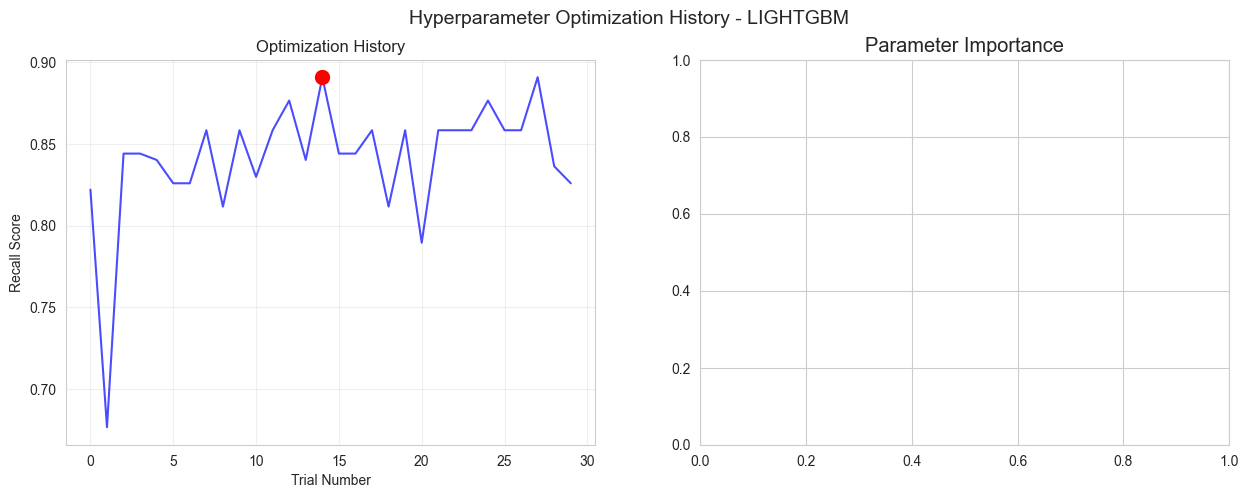

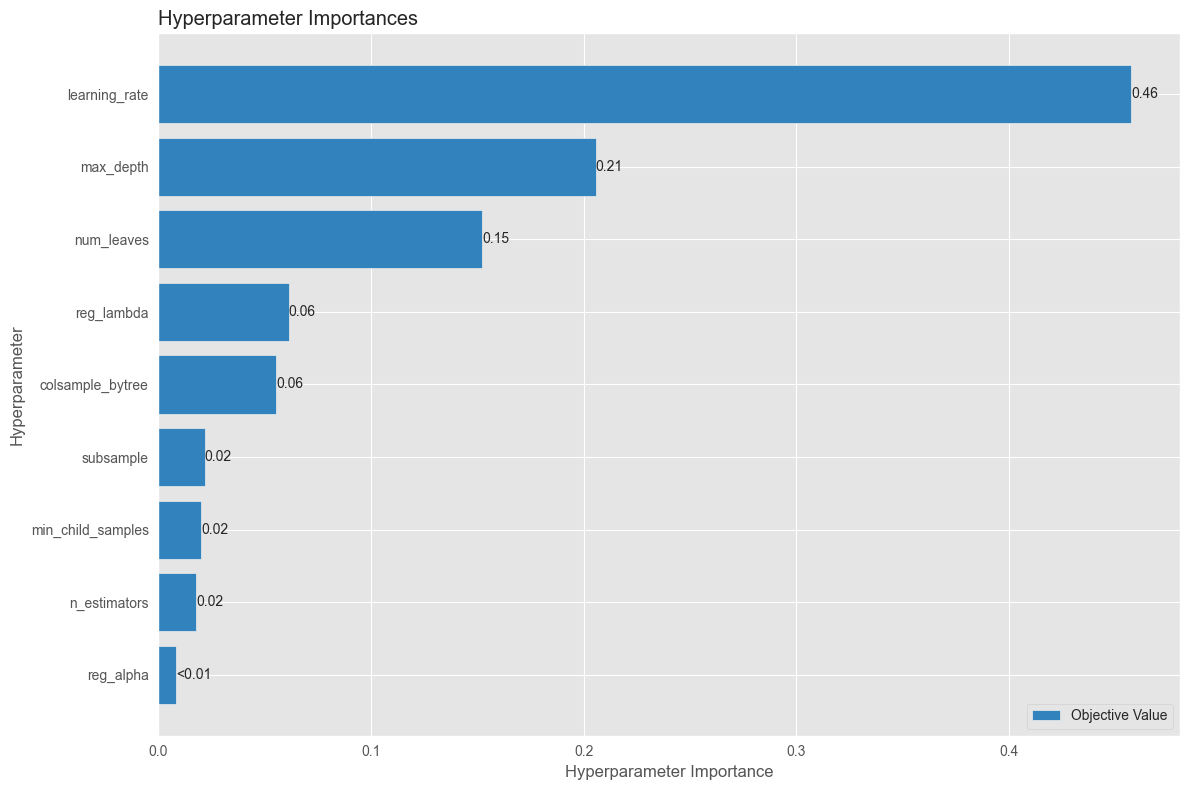

[OK] LIGHTGBM optimization complete!

[DEPLOYMENT] Optimizing XGBOOST hyperparameters...
🎯 Starting hyperparameter optimization for XGBOOST
   Trials: 30, CV Folds: 5
Best score: 0.8948
Optimization time: 403.38 seconds
Best score: 0.8948
Optimization time: 403.38 seconds


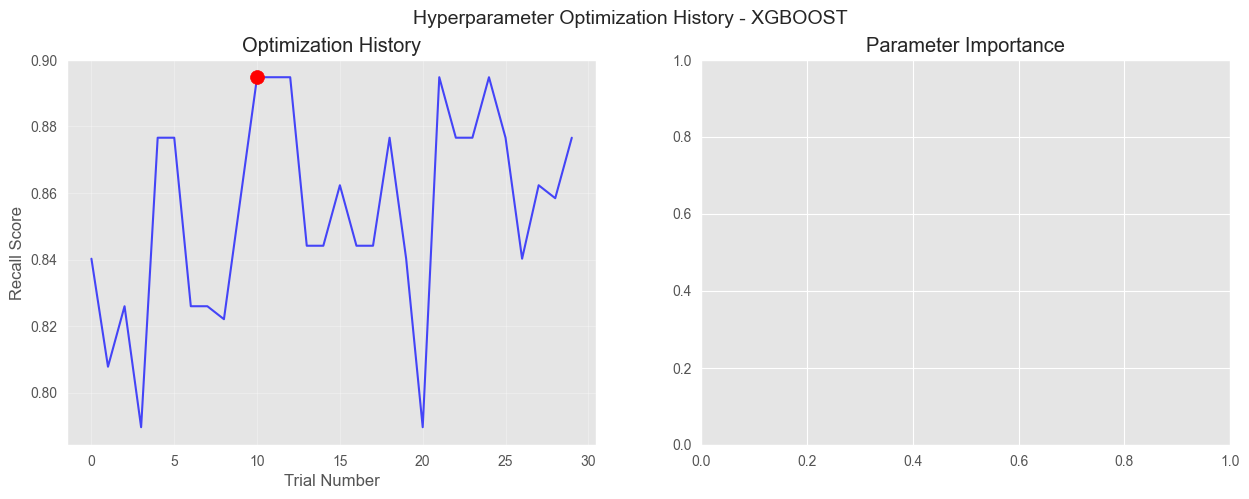

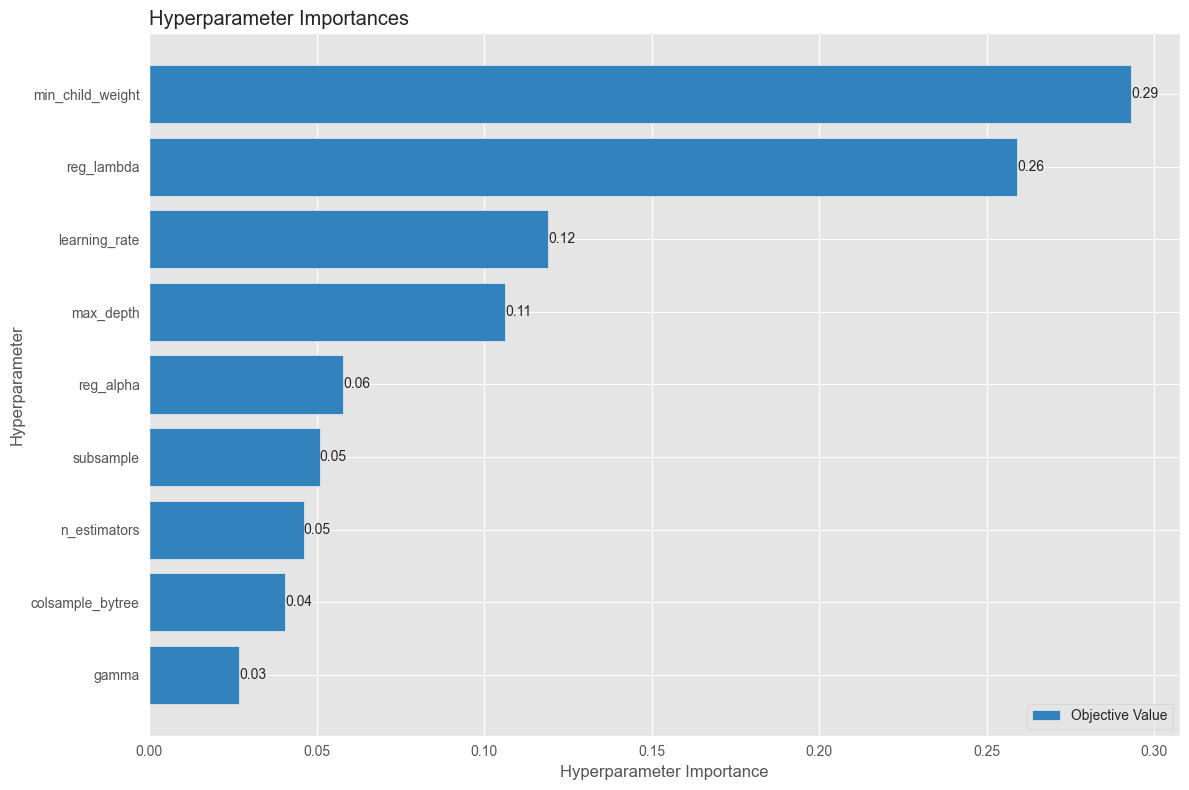

INFO:utils.data:[OK] Saved pickle to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\lightgbm_phase2_optimized.pkl
INFO:utils.data:[OK] Saved json to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\lightgbm_phase2_params.json
INFO:utils.data:[OK] Saved json to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\lightgbm_phase2_params.json
INFO:utils.data:[OK] Saved pickle to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\xgboost_phase2_optimized.pkl
INFO:utils.data:[OK] Saved json to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\xgboost_phase2_params.json
INFO:utils.data:[OK] Saved pickle to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\xgboost_phase2_optimized.pkl
INFO:utils.data:[OK] Saved json to c:\Users\gafeb\OneDrive\Desktop\lavagem_dev\artifacts\xgboost_phase2_params.json


[OK] XGBOOST optimization complete!

[OK] Hyperparameter optimization complete: 2 models optimized
[OK] Optimized models saved to artifacts directory


In [ ]:
# ============================================================================
# 3. ADVANCED HYPERPARAMETER OPTIMIZATION
# ============================================================================

print("=" * 80)
print("ADVANCED HYPERPARAMETER OPTIMIZATION")
print("=" * 80)

# Run comprehensive hyperparameter optimization using the new utils module
models_to_optimize = ['lightgbm', 'xgboost']
optimization_results = run_comprehensive_optimization(
    X_train_clean, y_train, cv_splits, models_to_optimize, n_trials=30
)

# Extract optimized models for further use
optimized_models = {}
for model_name, result in optimization_results.items():
    optimized_models[model_name] = result['model']
    print(f"\n{model_name.upper()} Optimization Results:")
    print(f"  Best CV Score: {result['best_score']:.4f}")
    print(f"  Best Parameters: {result['best_params']}")

# Save optimized models
for model_name, results in optimization_results.items():
    save_artifact(results['model'], ARTIFACTS_DIR / f'{model_name.lower()}_phase2_optimized.pkl')
    save_artifact(results['best_params'], ARTIFACTS_DIR / f'{model_name.lower()}_phase2_params.json')

print("[OK] Optimized models saved to artifacts directory")
print("=" * 80)

In [ ]:
# ============================================================================
# 5. ADVANCED FEATURE SELECTION
# ============================================================================

print("=" * 80)
print("🔍 ADVANCED FEATURE SELECTION")
print("=" * 80)

# Use best performing model for feature selection
best_model_name = max(phase1_models.keys(),
                     key=lambda x: phase1_results[x]['metrics']['recall'])
best_model = phase1_models[best_model_name]

print(f"Using {best_model_name} as base model for feature selection")

# Initialize advanced feature selector
feature_selector = AdvancedFeatureSelector()

# Perform comprehensive feature selection
selected_features_rfe = feature_selector.select_features_rfe(best_model, X_train_clean, y_train)
selected_features_permutation = feature_selector.select_features_permutation(best_model, X_train_clean, y_train)
selected_features_shap = feature_selector.select_features_shap(best_model, X_train_clean, y_train)

# Hybrid feature selection (consensus)
selected_features_hybrid = feature_selector.select_features_hybrid(best_model, X_train_clean, y_train)

# Evaluate feature selection impact
feature_sets = [
    X_train_clean.columns.tolist(),  # All features
    selected_features_rfe,  # RFE selected
    selected_features_permutation,  # Permutation selected
    selected_features_shap,  # SHAP selected
    selected_features_hybrid  # Hybrid selected
]

set_names = [
    'All Features',
    'RFE Selected',
    'Permutation Selected',
    'SHAP Selected',
    'Hybrid Selected'
]

# Evaluate impact using the utils function
from utils.feature_selection import evaluate_feature_selection_impact

selection_impact_results = evaluate_feature_selection_impact(
    best_model, X_train_clean, y_train, X_test_clean, y_test,
    feature_sets, set_names
)

# Save feature selection results
feature_selection_results = {
    'rfe_features': selected_features_rfe,
    'permutation_features': selected_features_permutation,
    'shap_features': selected_features_shap,
    'hybrid_features': selected_features_hybrid,
    'impact_results': selection_impact_results
}

save_artifact(feature_selection_results, ARTIFACTS_DIR / 'phase2_feature_selection_results.json')
save_artifact(selection_impact_results, ARTIFACTS_DIR / 'phase2_feature_selection_impact.json')

print("[OK] Feature selection analysis complete and saved")
print("=" * 80)

IndentationError: unexpected indent (753344383.py, line 111)